In [1]:
!pip list

Package                   Version
------------------------- --------------
absl-py                   2.1.0
anyio                     4.6.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
astunparse                1.6.3
async-lru                 2.0.4
attrs                     24.2.0
babel                     2.16.0
beautifulsoup4            4.12.3
bleach                    6.1.0
blinker                   1.8.2
certifi                   2024.8.30
cffi                      1.17.1
charset-normalizer        3.3.2
click                     8.1.7
cloudpickle               3.0.0
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.3.0
cycler                    0.12.1
debugpy                   1.8.6
decorator                 5.1.1
deepface                  0.0.93
defusedxml                0.7.1
doit                      0.36.0
executing                 2.1.0
fastjsonschema  

In [2]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [4]:
# for data load
import os

# # Libraries for reading and processing images
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io

# for visualizations
import matplotlib.pyplot as plt

import numpy as np # for using np arrays
import random

# for bulding and running deep learning model
import keras
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

# U-Net Decoder Block

This code defines the decoder block for the U-Net architecture, which is responsible for upsampling the feature maps and merging them with skip connections from the corresponding encoder block. The block starts with a transpose convolution layer to increase the size of the feature maps. Then, it merges the upsampled feature maps with the skip connection from the encoder block to preserve spatial information. Finally, two convolutional layers with ReLU activation and HeNormal initialization are applied to refine the features. This decoder block plays a vital role in reconstructing high-resolution segmentation masks from the encoded features, enabling the U-Net to produce accurate segmentation results.

In [5]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)

    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters,
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

# U-Net Encoder Block

This code defines the encoder block for the U-Net architecture, commonly used in image segmentation tasks. The block consists of two convolutional layers with ReLU activation and batch normalization for feature extraction. Optionally, dropout regularization is applied to prevent overfitting. If specified, max pooling is performed to downsample the spatial dimensions of the input. Additionally, a skip connection is established to preserve spatial information for the decoder part of the network. This encoder block plays a crucial role in extracting hierarchical features from the input image, facilitating the U-Net's ability to capture detailed information for accurate segmentation.

In [6]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning.
    Dropout can be added for regularization to prevent overfitting.
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow
    # Proper initialization prevents from the problem of exploding and vanishing gradients
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)

    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions
    skip_connection = conv

    return next_layer, skip_connection

# Constructing the U-Net Model

This function constructs the complete U-Net model by combining both the encoder and decoder blocks. The encoder consists of multiple convolutional mini-blocks with increasing filter sizes and varying configurations for max-pooling and dropout. Each encoder block produces a skip connection that is passed to the corresponding decoder block. The decoder reverses the process, gradually decreasing the number of filters while upsampling the feature maps and incorporating skip connections to preserve spatial information. Finally, the model is completed with convolutional layers to produce the desired output size, with the number of channels matching the specified number of output classes. This compiled U-Net model is ready for training and inference on segmentation tasks.

In [7]:
def UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=3):
   """
   Combine both encoder and decoder blocks according to the U-Net research paper
   Return the model as output
   """
   # Input size represent the size of 1 image (the size used for pre-processing)
   inputs = Input(input_size)

   # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
   # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image
   cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
   cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
   cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
   cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
   cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

   # Decoder includes multiple mini blocks with decreasing number of filters
   # Observe the skip connections from the encoder are given as input to the decoder
   # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
   ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
   ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
   ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
   ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

   # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
   # Followed by a 1x1 Conv layer to get the image to the desired size.
   # Observe the number of channels will be equal to number of output classes
   conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

   conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

   # Define the model
   model = tf.keras.Model(inputs=inputs, outputs=conv10)

   return model

# Building the U-Net Model

This code initializes the U-Net model by calling the UNetCompiled function, which defines the architecture of the neural network. The function takes parameters such as input size, number of filters, and number of output classes. In this case, the input image size is set to 128x128 with 3 channels (RGB), and the model is designed to have 32 filters in its layers and output into 3 classes. Additionally, the model is compiled, which involves configuring the training process with specific parameters such as loss function, optimizer, and metrics.

The three classes typically correspond to:

- Background: This class represents the background of the image, including areas that do not contain any pets.
- Foreground/Pet: This class represents the main subject of interest in the image, which is typically a pet (such as a cat or a dog).
- Boundary/Trimap: This class represents the boundary around the pet object, delineating its edges and helping to refine the segmentation.



In [8]:
# Call the helper function for defining the layers for the model, given the input image size
unet = UNetCompiled(input_size=(128,128,3), n_filters=32, n_classes=3)

Let's download and extract the Oxford-IIIT Pet Dataset. This dataset contains images of cats and dogs, along with annotations for pet breed and pixel-level segmentation masks. By downloading and extracting these files, we'll have access to the dataset for training and evaluating segmentation models.

### Download the datasets from the following links and extract them
https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

# Preprocessing and Dataset Construction

The following code loads images and their corresponding masks (annotations) from directories, preprocesses them, and constructs a TensorFlow dataset for training a segmentation model. It first collects file paths for images and masks, then defines functions to load and preprocess them using TensorFlow's IO and image processing modules. After defining a function to create a dataset from these paths, it constructs the dataset using specified batch size and image size. Finally, it iterates through the dataset, collecting batches of input images and target masks into arrays, which are then concatenated to form the complete input and target datasets for training the segmentation model.

In [39]:
# replace with your relative paths

input_dir = r'C:\LAU files\MSc. AAI\AAI613O - Comput.Vis and its Applications\Week 4\images\images'
target_dir = r'C:\LAU files\MSc. AAI\AAI613O - Comput.Vis and its Applications\Week 4\annotations\annotations\trimaps'
img_size = (128, 128)
batch_size = 32

input_img_paths = sorted([
    os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith(".jpg")
])

target_img_paths = sorted([
    os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")
])

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

def load_img_masks(input_img_path, target_img_path):
    input_img = tf_io.read_file(input_img_path)
    input_img = tf_io.decode_jpeg(input_img, channels=3)
    input_img = tf_image.resize(input_img, img_size)
    input_img = tf_image.convert_image_dtype(input_img, tf.float32)

    target_img = tf_io.read_file(target_img_path)
    target_img = tf_io.decode_png(target_img, channels=1)
    target_img = tf_image.resize(target_img, img_size, method="nearest")
    target_img = tf.squeeze(target_img, axis=-1)  # Remove the channel dimension
    target_img = tf_image.convert_image_dtype(target_img, tf.uint8)

    # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
    target_img -= 1
    return input_img, target_img

def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""
    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

# Get the dataset
dataset = get_dataset(
    batch_size=batch_size,
    img_size=img_size,
    input_img_paths=input_img_paths,
    target_img_paths=target_img_paths
)

# Collect batches from the dataset into arrays or tensors
X_batches = []
y_batches = []
for X_batch, y_batch in dataset:
    X_batches.append(X_batch.numpy())  # Convert TensorFlow tensor to numpy array
    y_batches.append(y_batch.numpy())  # Convert TensorFlow tensor to numpy array

# Concatenate batches into a single array or tensor
X = np.concatenate(X_batches, axis=0)
y = np.concatenate(y_batches, axis=0)


Number of samples: 7390
C:\LAU files\MSc. AAI\AAI613O - Comput.Vis and its Applications\Week 4\images\images\Abyssinian_1.jpg | C:\LAU files\MSc. AAI\AAI613O - Comput.Vis and its Applications\Week 4\annotations\annotations\trimaps\Abyssinian_1.png
C:\LAU files\MSc. AAI\AAI613O - Comput.Vis and its Applications\Week 4\images\images\Abyssinian_10.jpg | C:\LAU files\MSc. AAI\AAI613O - Comput.Vis and its Applications\Week 4\annotations\annotations\trimaps\Abyssinian_10.png
C:\LAU files\MSc. AAI\AAI613O - Comput.Vis and its Applications\Week 4\images\images\Abyssinian_100.jpg | C:\LAU files\MSc. AAI\AAI613O - Comput.Vis and its Applications\Week 4\annotations\annotations\trimaps\Abyssinian_100.png
C:\LAU files\MSc. AAI\AAI613O - Comput.Vis and its Applications\Week 4\images\images\Abyssinian_101.jpg | C:\LAU files\MSc. AAI\AAI613O - Comput.Vis and its Applications\Week 4\annotations\annotations\trimaps\Abyssinian_101.png
C:\LAU files\MSc. AAI\AAI613O - Comput.Vis and its Applications\Week 4

In [40]:
# Use scikit-learn's function to split the dataset
# 20% data as test/valid set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

# Training the UNet Model for Image Segmentation on the Oxford Dataset

This code compiles and trains a UNet model for image segmentation using the Oxford dataset. It configures the model with the Adam optimizer and sparse categorical crossentropy loss function, suitable for integer-based target labels. Additionally, it includes a ModelCheckpoint callback to save the best model during training and runs training for 20 epochs, validating the model's performance after each epoch.

In [41]:
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]

# Run the model in a mini-batch fashion and compute the progress for each epoch
results = unet.fit(X_train, y_train, batch_size=32, epochs=20,
                    validation_data=(X_valid, y_valid),callbacks=callbacks,)

Epoch 1/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 141s 741ms/step - accuracy: 0.5219 - loss: 1.0162 - val_accuracy: 0.6778 - val_loss: 0.7606
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 141s 760ms/step - accuracy: 0.7774 - loss: 0.5552 - val_accuracy: 0.7415 - val_loss: 0.6619
Epoch 3/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 140s 758ms/step - accuracy: 0.8141 - loss: 0.4665 - val_accuracy: 0.8055 - val_loss: 0.4955
Epoch 4/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 140s 760ms/step - accuracy: 0.8392 - loss: 0.4105 - val_accuracy: 0.8265 - val_loss: 0.4453
Epoch 5/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 140s 758ms/step - accuracy: 0.8531 - loss: 0.3758 - val_accuracy: 0.8127 - val_loss: 0.5097
Epoch 6/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 140s 758ms/step - accuracy: 0.8655 - loss: 0.3422 - val_accuracy: 0.8387 - val_loss: 0.4214
Epoch 7/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 141s 760ms/step - accuracy: 0.8728 - loss: 0.3245 - val_accuracy: 0.8472 - val_loss: 0.4116
Epoch 8/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 140s 756ms/step - accuracy: 0.8825 -

# Displaying Predicted Masks Alongside Input Images and Actual Masks

47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step


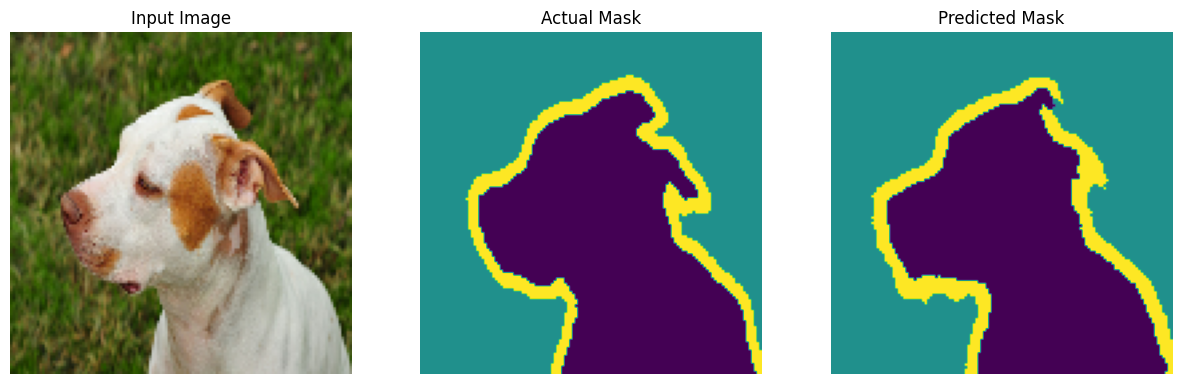

In [45]:
# Generate predictions for all images in the validation set
val_preds = unet.predict(X_valid)

def display_masks_side_by_side(input_image, actual_mask, predicted_mask):
    """Display input image, actual mask, and predicted mask side by side."""
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Display input image
    # Normalize input image to range [0, 1]
    input_image_norm = input_image.astype(np.float32) / 255.0

    axs[0].imshow(input_image_norm)
    axs[0].set_title('Input Image')
    axs[0].axis('off')

    # Display actual mask
    axs[1].imshow(actual_mask)  # Remove indexing since actual_mask is a 2D array
    axs[1].set_title('Actual Mask')
    axs[1].axis('off')

    # Convert predicted mask to numpy array
    predicted_mask_np = np.argmax(predicted_mask, axis=-1)

    # Display predicted mask
    axs[2].imshow(predicted_mask_np)
    axs[2].set_title('Predicted Mask')
    axs[2].axis('off')

# Display results for validation image #10
i = 15

# Load input image (assuming X_valid contains the input images)
input_image =X_valid[i]

# Load actual mask (assuming y_valid contains the actual masks)
actual_mask = y_valid[i]

# Display input image, actual mask, and predicted mask side by side
display_masks_side_by_side(input_image, actual_mask, val_preds[i])
